## Fantastic regularizations and where to find them

The ptychographic classes we have been introducing in the previous tutorials have a lot of optional parameters, notably various object/probe regularizations. This notebook serves as a non-exhaustive, semi-curated documentation for these options.

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Updated 2023 Oct 31

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.14.8


### Data

We'll use the ducky dataset to test our regularizations on:
- Simulated ducky ([dataset](https://drive.google.com/file/d/1uyeQAQa4DaMwHqN9EHQFCMKAve0_Fgfz/view?usp=share_link), [vacuum probe](https://drive.google.com/file/d/1xJgQoxhWMBbtknwRfqB_BkULvgiJe-c1/view?usp=share_link)) 

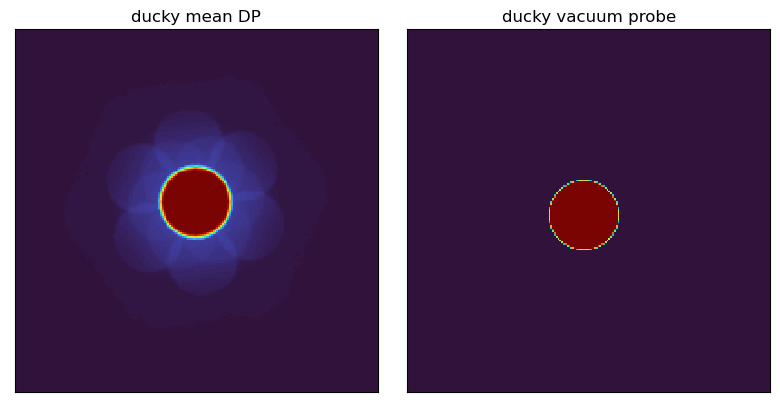

In [2]:
data_path = 'data/'
ducky_data_file = data_path + 'ptycho_sim_01_data.h5'
ducky_probe_file = data_path + 'ptycho_sim_01_probe.h5'

ducky_dataset = py4DSTEM.read(ducky_data_file)
ducky_dataset.calibration.set_Q_pixel_size(0.025)
ducky_dataset.calibration.set_Q_pixel_units('A^-1')
ducky_dataset.calibration.set_R_pixel_size(5.0)
ducky_dataset.calibration.set_R_pixel_units('A')

ducky_probe = py4DSTEM.read(ducky_probe_file)

py4DSTEM.show(
    [
        ducky_dataset.data.mean((0,1)),
        ducky_probe.data,
    ],
    cmap='turbo',
    power=0.5,
    ticks=False,
    axsize=(4,4),
    title= [
        "ducky mean DP",
        "ducky vacuum probe",
    ]
)

### Initialization Arguments

First, let's cover the different initialization arguments.

- The minimum set of arguments you need are:
  - `datacube`: py4DSTEM.DataCube object with proper calibrations
  - `energy`: accelerating voltage in eV
  - one of two ways of specifying the probe aperture:
    - `vacuum_probe_intensity`: experimentally-obtained vacuum-probe intensity measurement
    - `semiangle_cutoff`: ideal aperture size in mrad
    
_Notes:_
- You can also specify the semiangle in pixels `semiangle_cutoff_pixels` if you prefer
- If you're using an ideal aperture, you can also specify the `rolloff` width in mrad (defaults to 2mrad)

In [3]:
ducky_ptycho_ss = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=ducky_dataset,
    energy=80e3,
    vacuum_probe_intensity = ducky_probe.data,
    # semiangle_cutoff=20,
    # rolloff=2,
)

In addition, you can optionally specify the initial probe aberrations. This is particularly important for defocused-ptychography.  
These can be specified one of two ways:
- `polar_parameters`: a dictionary of polar aberrations in Angstroms, e.g. `polar_parameters={'C10':-600}`
- directly as keyword arguments, e.g. `defocus=600`

_Notes:_
- These are not limited to defocus, although it's often hard to estimate higher order aberrations
- We use the same conventions as the `abtem` CTF described [here](https://abtem.github.io/doc/user_guide/walkthrough/contrast_transfer_function.html#phase-aberrations)

In [4]:
ducky_ptycho_ss = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=ducky_dataset,
    energy=80e3,
    vacuum_probe_intensity = ducky_probe.data,
    # semiangle_cutoff=20,
    # rolloff=2,
    defocus=600,
    #device='gpu',
)

You can also specify some top-level configuration options, notably:
- `verbose`: True/False - specifies the reconstruction verbosity
- `device` : 'cpu'/'gpu' - specifies the device on which calculations will be performed
- `name` : Object name. Used in specifying the hdf5 directory structure during read/write


The are also two reconstruction-specific options which need to be specified during initialization (for read/write functionality):
- `object_padding_px`: Padding around the object's fov, used to minimize wrap-around artifacts
- `object_type`: 'complex'/'potential' - Specifies if the object array is stored as a complex object or simply as the scalar-valued potential. See object regularization section below.

Finally, you can also specify the initial object, probe, and probe-positions explicitly using:
- `initial_object_guess`  
- `initial_probe_guess`  
- `initial_scan_positions`  

This is are useful for example in re-starting calculations (although using the `py4DSTEM.save/read` functions will do this automatically).

#### Class-specific Initialization Arguments

The arguments above apply for all the ptycho class in py4DSTEM. For additional functionality, some classes require additional arguments - namely:

- `MixedstatePtychographicReconstruction`
  - `num_probes`: # of mixed-state probes to use
- `MultislicePtychographicReconstuction`
  - `num_slices`: # of slices to use
  - `slice_thicknesses` slice thickness for each slice in A
- `SimultaneousPtychographicReconstruction`
  - `datacube`: a sequence of DataCubes
  - `simultaneous_measurements_mode`: '-+'/'-0+'/'0+', where -/0/+ refer to the sign of the magnetic potential
- `OverlapTomographicReconstruction`
  - `num_slices`: # of slices to use
  - `tilt_angles_deg`: sequence of tilt-angles around x-axis for each measurement
  - `datacube`: sequence of DataCubes
- `OverlapMagneticTomographicReconstruction`
  - `num_slices`: # of slices to use
  - `tilt_angles_deg`: sequence of two euler-angles for each measurement
  - `datacube`: sequence of DataCubes

### Preprocessing Arguments

The next step is to preprocess the DataCube(s), which expose additional arguments.  
First, we can upsample/downsample our diffraction patterns using:

- `diffraction_intensities_shape`: size of diffraction patterns
- `reshaping_method`: 'fourier'/'bilinear'/'bin' - If `diffraction_intensities_shape` evenly divides the initial datacube's shape, we recommend you use 'bin'.
- `probe_roi_shape`: size of the probe ROI. Needs to be larger or equal to the diffraction patterns and will result in padding diffraction patterns (use sparingly)

In general, it's beneficial to bin the DPs enough to boost the SNR - while still be able to comfortambly fit the probe without wrap-around artifacts (see dedicated notebook [here](https://github.com/py4dstem/py4DSTEM_tutorials/blob/main/notebooks/ptycho00_dangerous-to-go-alone.ipynb)).

The next important set of arguments corresponds to calculating the center-of-mass quantities and using them to fit de-scan:
- `dp_mask`: binary mask to multiply diffraction patterns before computing CoM
- `fit_function`: 'constant'/'plane'/'parabola'/'bezier_two' - fitting function to estimate descan from measured CoM
- `force_com_shifts`: by-pass CoM computation and directly pass fitted CoM array

The defaults for these should mostly work well.

Ptychography requires an accurate guess for the relative rotation between the real-space scan positions and the diffraction patterns' coordinate system.  
By default, we use the curl of the computed CoM gradient (which should vanish by construction in the correct coordinate system) to estimate this. The following arguments pertain to solving for the rotation and orientation of the DPs:
- `maximize_divergence`: True/False - If True, the divergence is maximized instead of the curl being minimized
- `rotation_angles_deg`: array of rotation angles in degrees to compute minimum curl on (default is -90 to 90 in 1 deg increments)
- `force_com_rotation`: by-pass rotation calculation and instead fix rotation value
- `force_com_transpose`: by-pass orientation calculation and instead fix transpose value

We also provide various plotting utilities to evaluate the preprocessing step:
- `plot_rotation`: True/False - Plot curl/divergence minimization/maximization
- `plot_center_of_mass`: 'default','all',False - Plots calculated/fitted/corrected CoM
- `plot_probe_overlaps`: True/False - Plots initialized probe and object fov with probe overlaps

We recommend always plotting the probe overlaps when you first start a reconstruction, as it provides insight into two important aspects necessary for good ptychography:
- no wrap-around artifacts in the probe
- 'sufficient' probe overlap (see dedicated notebook [here](https://github.com/py4dstem/py4DSTEM_tutorials/blob/main/notebooks/ptycho00_dangerous-to-go-alone.ipynb))

Best fit rotation = -15 degrees.
No need to transpose diffraction intensities.


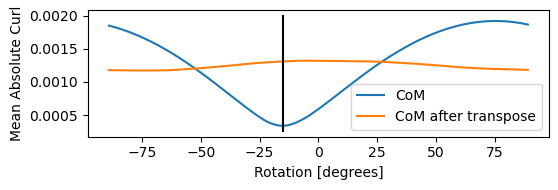

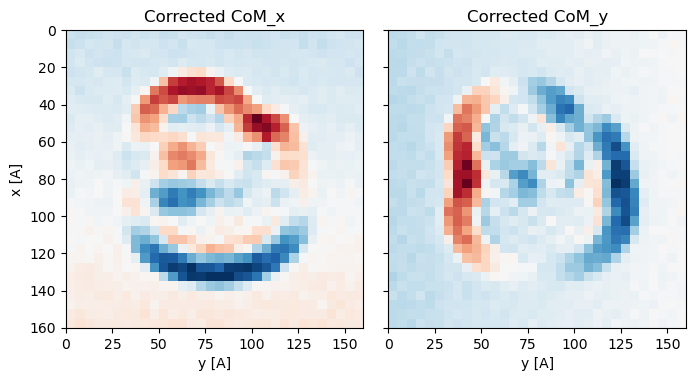

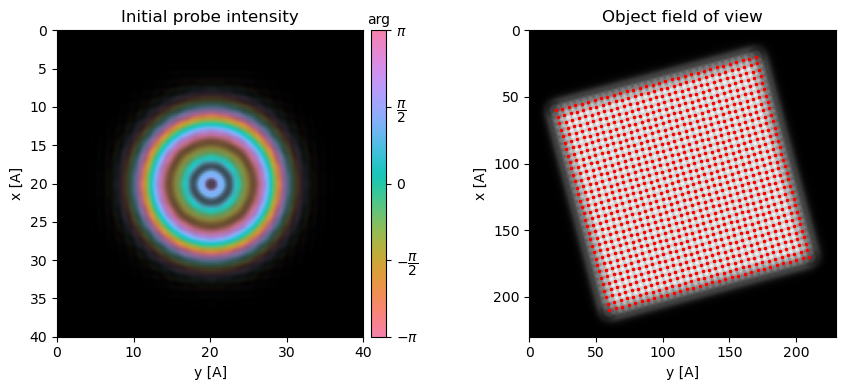

In [5]:
ducky_ptycho_ss = ducky_ptycho_ss.preprocess(
    plot_center_of_mass = 'default',
    plot_rotation = True,
    plot_probe_overlaps = True,
)

Finally, you can force the real-space/angular sampling using:
- `force_scan_sampling`
- `force_angular_sampling`
- `force_reciprocal_sampling`

_Note_: We actually recommend _against_ using these arguments directly. These are mostly provided such that the Bayesian Optimizer can fine-tune these automatically. If you wish to set your calibrations - please set the DataCube calibrations prior to running ptychography.

### Reconstruction Arguments

There are a lot of reconstruction arguments, most of which pertain to the use of regularizations (which we elaborate on below). Here, we simply comment on general reconstruction arguments:
- `max_iter` : # of iterations to run
- `reconstruction_method`: "gradient-descent"/"difference-map_alternating-projections"/"relaxed-averaged-alternating-reflections"/"relax-reflect-reflect"/"generalized-projections"
- `step_size`: gradient descent step-size
- `reconstruction_parameter/_a/_b/_c` : reconstruction parameter(s) for projection-set methods (see docstrings)
- `reset`: True/False - whether to start from previous reconstruction or initialized guesses
- `progress_bar`: True/False - whether to show progress bar
- `store_iterations`: True/False - whether to store probe/object for each iteration
- `normalization_min`: Regularization parameter between 0-1
- `max_batch_size`: If using gradient descent, how many probe positions to use at a time

_Notes_:
- `max_batch_size=None` (default) corresponds to using all probe positions for updating the probe and object. We have seen this to result in fastest convergence for the object, but slow to converge probe updates
- `max_batch_size=1` corresponds to e-PIE style updates. We recommend against this, since it's rather slow and in our experience often unstable. However, using a small batch size does have advantages (see e.g. the [mixed-state tutorial](https://github.com/py4dstem/py4DSTEM_tutorials/blob/main/notebooks/ptycho04_STO-mixedstate.ipynb)), and allows for a smaller memory usage.

Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.0.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.74 iter/s]


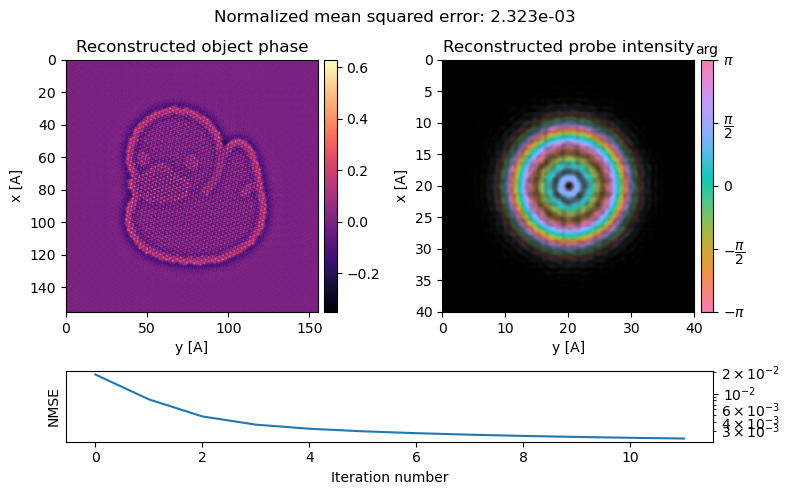

In [6]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    progress_bar = True,
    store_iterations = True,
    max_iter = 12,
    normalization_min=0.0,
).visualize()

### Object Regularizations

Great, now we're finally in a position to talk about regularizations!  
We'll start with the object, which in the simplest case is stored as a complex array
$$
\mathcal{O} = A \exp{i V}
$$

- `pure_phase_object_iter`: Specifies the number of iterations to run as a pure-phase object  
The object form above assumes the reconstructed object has both amplitude and phase information. However, for weakly-scattering objects - it is often the case that the amplitude loss should be rather minimal. We can enforce this by setting the reconstructed amplitude to unity after each iteration. This helps reduce the dimensionality of the problem and is often a good starting point

Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.0.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.85 iter/s]


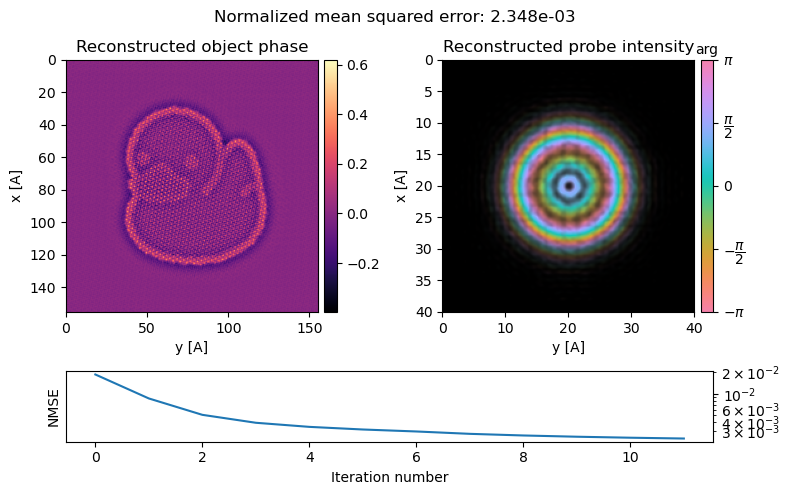

In [7]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    pure_phase_object_iter=6,
    normalization_min=0.0,
).visualize()

- `switch_object_iter`: Specifies the number of iterations to run before switching `object_type`  
In-fact, if we only care about the phase - then instead of constraining the amplitude after each iteration, we can simply update the potential directly. This can be specified either by setting `object_type='potential'` during initialization (the recommended way), or by specifying a "switch" iteration during reconstructions. e.g. here we perform 4 iterations using a complex object before switching to a potential object:

Performing 4 iterations using a complex object type and 8 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 0.0.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.99 iter/s]


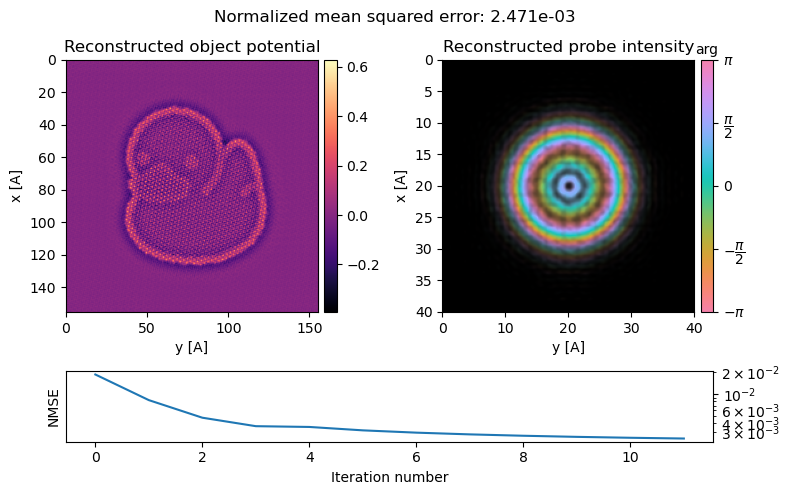

In [8]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    switch_object_iter=4,
    normalization_min=0.0,
    object_positivity = False,
).visualize()

- `object_positivity`: True/False  
If we're dealing with a scalar-valued potential object, we can additionally enforce a much stronger constraint that the potential be non-negative by clipping negative values at each iteration.

Performing 0 iterations using a potential object type and 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.0.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.74 iter/s]


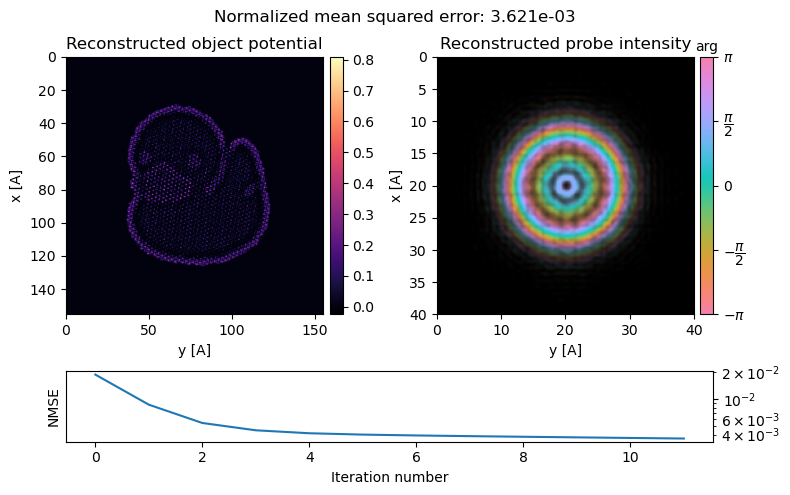

In [9]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    switch_object_iter=0,
    object_positivity=True,
    normalization_min=0.0,
).visualize()

- `shrinkage_rad`  
We can go even further by subtracting a constant amount of phase at every iteration before clipping to zero. This has the effect of "boosting" strong signals thus promoting "atomicity".  
_Note:_ This is rather finicky and should be used sparingly.

Performing 0 iterations using a potential object type and 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.0.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.80 iter/s]


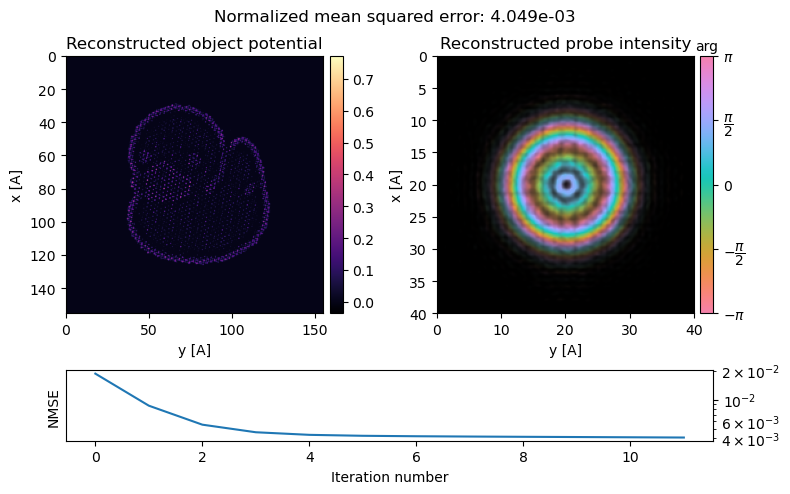

In [10]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    switch_object_iter=0,
    object_positivity=True,
    normalization_min=0.0,
    shrinkage_rad=1e-2,
).visualize()

- `gaussian_filter_sigma` & `gaussian_filter_iter`  
If we don't have a lot of redundant information in our dataset, our reconstructions tend to inject a lot of high-frequency artifacts.  These can be suprressed by "smoothing" the object using real-space gaussian filtering

Performing 12 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.84 iter/s]


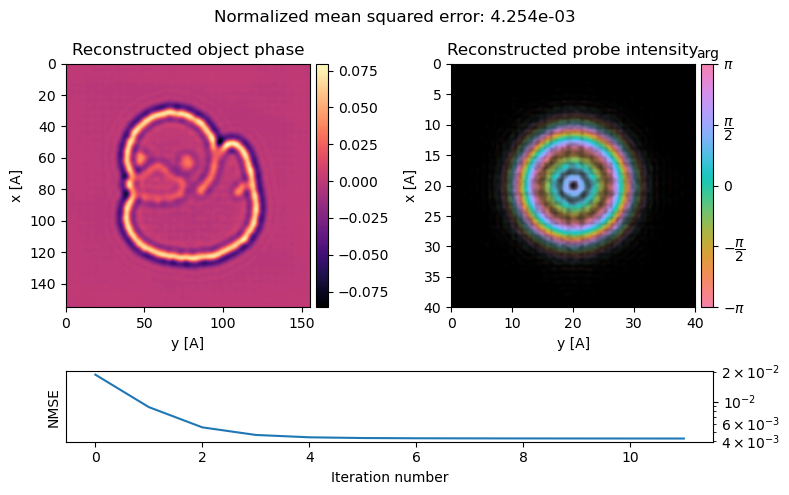

In [11]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    gaussian_filter_sigma=1.0,# A (exaggerated for demonstration)
).visualize()

- `q_lowpass`, `q_highpass`, `butterworth_order`, and `butterworth_filter_iter`  
We can also filter the object in reciprocal-space, using a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) - to either high-,low-, or band-pass the object

Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.50 iter/s]


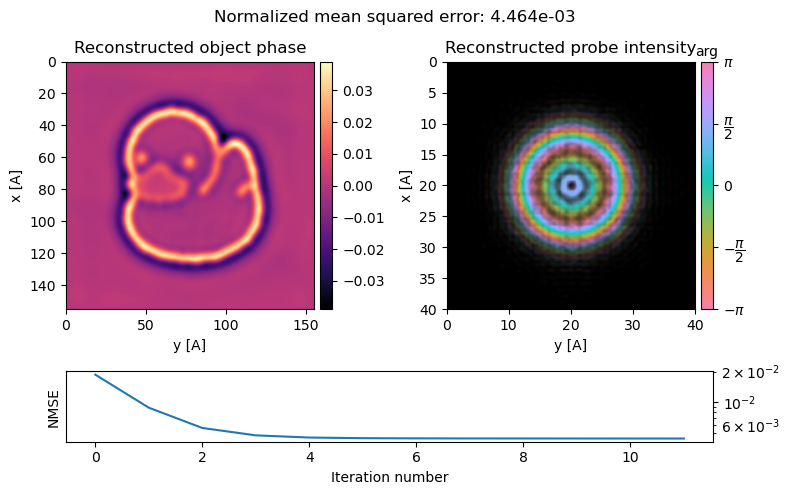

In [12]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    q_lowpass=0.1,# 1/A (exaggerated for demonstration)
).visualize()

### Probe Regularizations

We now switch to STEM-specific probe regularizations.

First, let's do a reconstruction with any of these and plot the reconstructed probe in Fourier-space to identify potential issues:

Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.91 iter/s]


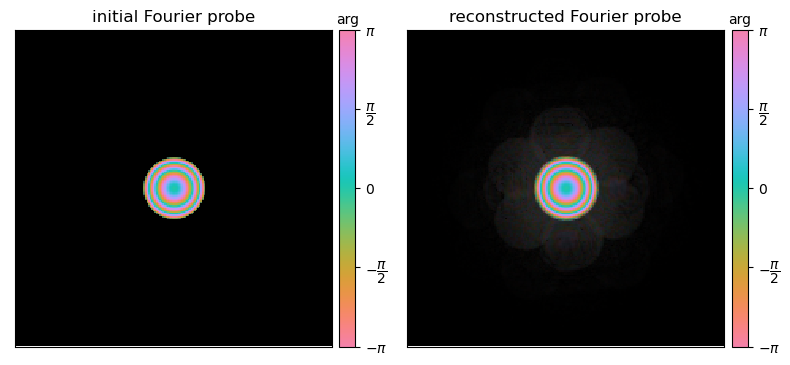

In [13]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    progress_bar = True,
    store_iterations = True,
    max_iter = 12,
)

initial_fourier_probe = ducky_ptycho_ss._asnumpy(
    ducky_ptycho_ss._return_fourier_probe(
        ducky_ptycho_ss._probe_initial
    )
)

reconstructed_fourier_probe = ducky_ptycho_ss.probe_fourier

py4DSTEM.show_complex(
    [
        initial_fourier_probe,
        reconstructed_fourier_probe,
    ],
    axsize=(4,4),
    power=0.5,
    ticks=False,
    title= [
        "initial Fourier probe",
        "reconstructed Fourier probe"
    ]
)

In this case, our initial aberrations were pretty accurate - so the phase doesn't change much. However, our probe aperture changes significantly, with the reconstructed aperture having intensity past the BF disk. This is a consequence of our FOV being fully-periodic, thus the "Fourier projection" is always injecting scattered intensity into the gradient step, effectively mixing the probe and the object.

- `fix_probe_iter`: Number of iterations to run with the probe fixed  
The simplest constraint is not to update the probe at all. This requires we know our initial aperture and aberrations perfectly so is rather impractical.

Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.34 iter/s]


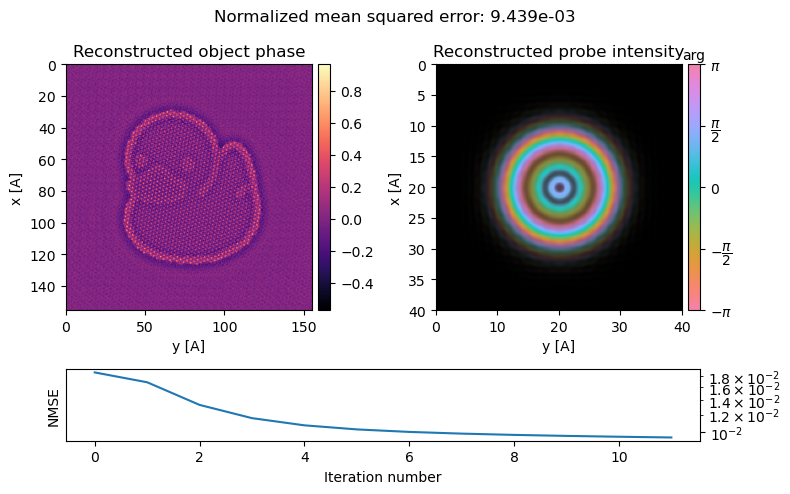

In [14]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    fix_probe_iter=12,
).visualize()

- `fix_probe_aperture_iter`: Number of iterations to run with the probe aperture fixed  
If we have a high fidelity vacuum probe measurement, then we can ensure that gets respected at each iteration

Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.85 iter/s]


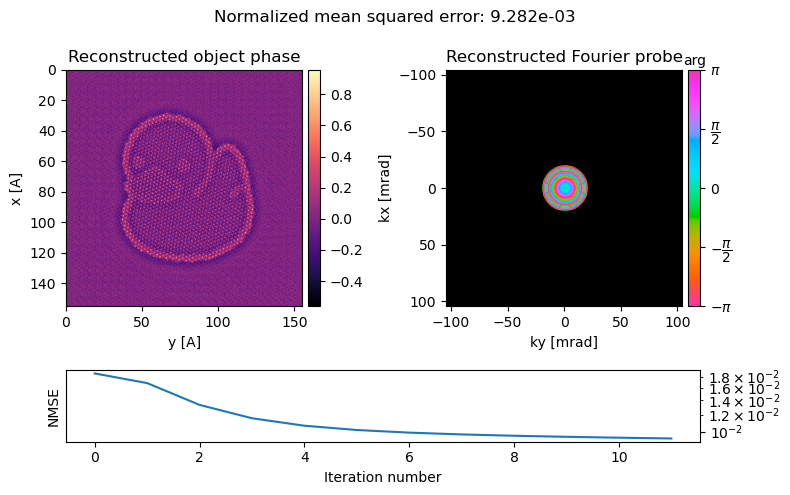

In [15]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 12,
    fix_probe_aperture_iter=12,
).visualize(
    plot_fourier_probe=True
)

- `constrain_probe_fourier_amplitude_iter`: Number of iterations to run by fitting a sigmoid to the probe aperture  
If we don't have a good vacuum probe, we can instead fit a sigmoid for each angular frequency at each iteration.  

_Note:_ This is currently fairly unstable and poorly-tested (we're working on it!)

Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.70 iter/s]


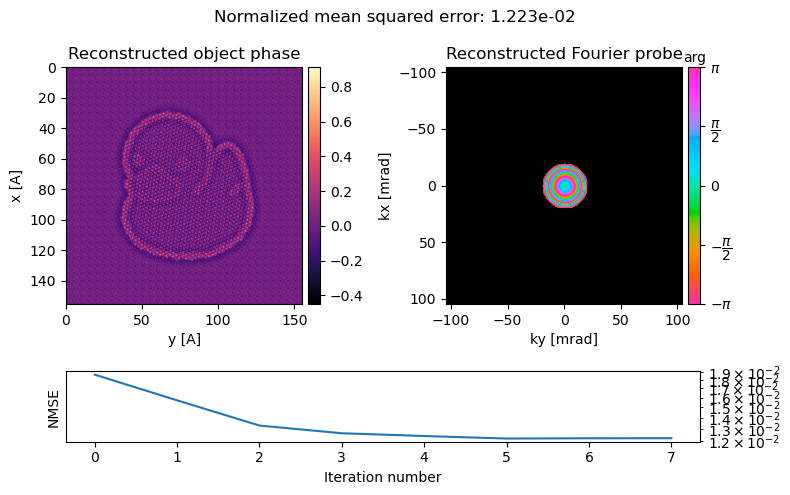

In [16]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 8,
    constrain_probe_fourier_amplitude_iter=8,
    constrain_probe_fourier_amplitude_constant_intensity=False,
    constrain_probe_fourier_amplitude_max_width_pixels=1,
).visualize(
    plot_fourier_probe=True
)

- `fit_probe_aberrations_iter`, `fit_probe_aberrations_max_angular_order`, and `fit_probe_aberrations_max_radial_order`  
Turning back to our phase, we want to ensure this is fairly smoothly varying - as sharp changes in aberrations are fairly unphysical. We achieve this by fitting our aberration surface at each iteration to a low-order linear basis function  

_Note:_ This requires unwrapping the phase before fitting. We currently perform this using an external library (`scikit-image`) which unfortunately occasionally hangs the kernel.. (we're working on it!)

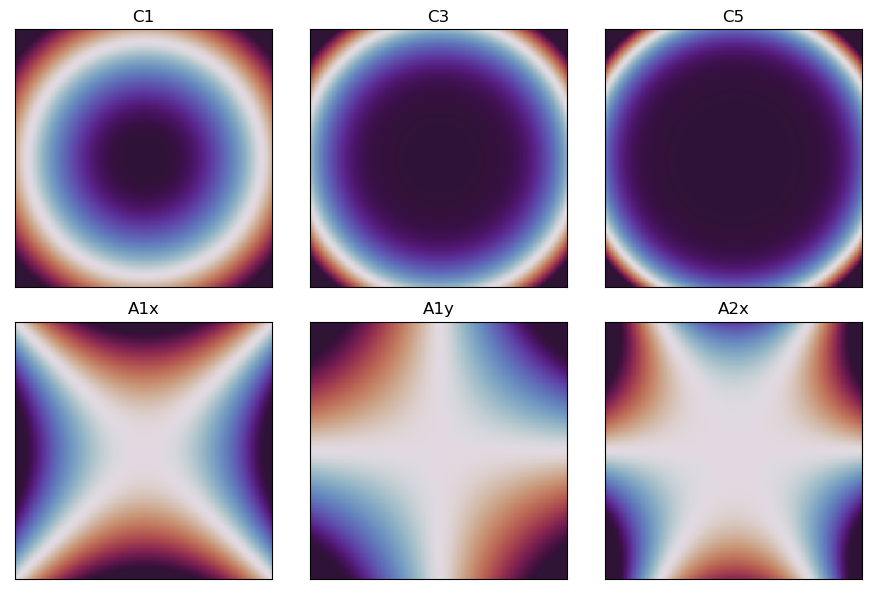

In [27]:
size = ducky_ptycho_ss._region_of_interest_shape

basis, index = py4DSTEM.process.phase.utils.aberrations_basis_function(
    probe_size= size,
    probe_sampling = ducky_ptycho_ss.sampling,
    energy=ducky_ptycho_ss._energy,
    max_angular_order = 5,
    max_radial_order = 6,
)

basis_wrapped = np.mod(basis - np.pi,2*np.pi) + np.pi

py4DSTEM.show(

    [
        [
            np.fft.fftshift(basis_wrapped[:,1].reshape(size)),
            np.fft.fftshift(basis_wrapped[:,2].reshape(size)),
            np.fft.fftshift(basis_wrapped[:,3].reshape(size)),
        ],
      [
            np.fft.fftshift(basis_wrapped[:,4].reshape(size)),
            np.fft.fftshift(basis_wrapped[:,5].reshape(size)),
            np.fft.fftshift(basis_wrapped[:,8].reshape(size)),
        ],
    ],
    cmap='twilight_shifted',
    title=["C1","C3","C5","A1x","A1y","A2x"],
    axsize=(3,3),
    ticks=False,
)

Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.52 iter/s]


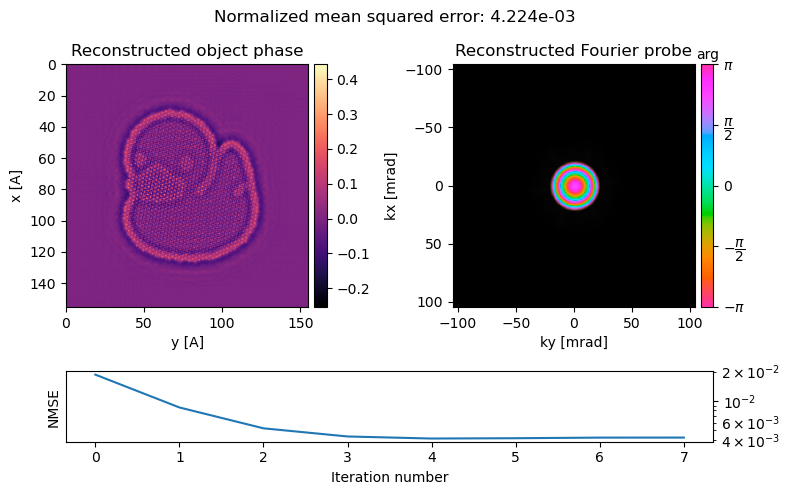

In [28]:
ducky_ptycho_ss = ducky_ptycho_ss.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 8,
    fit_probe_aberrations_iter=8,
    fit_probe_aberrations_max_angular_order=0, # fit only
    fit_probe_aberrations_max_radial_order=2, # defocus
).visualize(
    plot_fourier_probe=True
)